In [0]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])

df.drop("id", inplace=True, axis=1)

# Generate dummies for job
df = pd.concat([df,pd.get_dummies(df['job'],prefix="job")],axis=1)
df.drop('job', axis=1, inplace=True)

# Generate dummies for area
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)

nonna = df[df["income"].notna()]
isna = df[df["income"].isnull()]
nx = nonna.drop(["income", "product"], axis=1).values
ny = nonna["income"].values
nx_train, nx_test, ny_train, ny_test = train_test_split(nx, ny, test_size=0.2)
reg = LinearRegression().fit(nx_train, ny_train)
isna["income"] = reg.predict(isna.drop(["income", "product"], axis=1).values)
df = pd.concat([isna, nonna], axis=0)
reg.score(nx_test, ny_test)

df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['age'] = zscore(df['age'])
df['subscriptions'] = zscore(df['subscriptions'])
df['dist_healthy'] = zscore(df['dist_healthy'])
df['dist_unhealthy'] = zscore(df['dist_unhealthy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
x_columns = df.columns.drop('product')
x = df[x_columns].values
dummies = pd.get_dummies(df['product']) # Classification
products = dummies.columns
y = dummies.values
df.head()

,income,aspect,subscriptions,dist_healthy,save_rate,dist_unhealthy,age,pop_dense,retail_dense,crime,product,job_11,job_al,job_am,job_ax,job_bf,job_by,job_cv,job_de,job_dz,job_e2,job_f8,job_gj,job_gv,job_kd,job_ke,job_kl,job_kp,job_ks,job_kw,job_mm,job_nb,job_nn,job_ob,job_pe,job_po,job_pq,job_pz,job_qp,job_qw,job_rn,job_sa,job_vv,job_zz,area_a,area_b,area_c,area_d
35,0.034691,-0.494600,-0.208449,-0.670247,-0.387695,-1.105761,1.124377,0.874016,0.417323,0.238394,b,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
69,0.033469,-0.996591,-0.208449,-0.000942,-0.542432,-1.169511,0.314210,0.858268,0.503937,0.263349,c,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
101,0.730732,1.360973,-1.255928,1.294946,-0.353308,-0.310185,-0.495957,0.925197,0.692913,0.086156,c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
134,-0.198250,-1.408940,-0.208449,-0.247778,0.282834,-0.487775,-0.495957,0.826772,0.586614,0.303499,c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
155,0.645427,0.724521,-0.208449,0.644628,0.661081,2.321132,-0.766013,0.992126,0.775591,0.443469,b,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [4]:
kf = StratifiedKFold(5, shuffle=True, random_state=69)

oos_y = []
oos_pred = []
fold = 0

for train, test in kf.split(x, df["product"]):
  fold += 1
  print(f"Fold #{fold}")

  x_train = x[train]
  x_test = x[test]
  y_train = y[train]
  y_test = y[test]

  model = Sequential()
  model.add(Dense(50, input_dim=x.shape[1], activation="relu"))
  model.add(Dropout(0.5))
  model.add(Dense(25, activation="relu", activity_regularizer=regularizers.l2(1e-4)))
  model.add(Dense(y.shape[1], activation="softmax"))
  model.compile(loss="categorical_crossentropy", optimizer="adam")
  model.fit(x_train, y_train, validation_data=(x_test, y_test), verbose=0, epochs=500)

  pred = model.predict(x_test)
  pred = np.argmax(pred, axis=1)
  y_compare = np.argmax(y_test, axis=1)

  score = metrics.accuracy_score(y_compare, pred)
  print(f"Fold accuracy: {score}")

  oos_y.append(y_compare)
  oos_pred.append(pred)

oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = metrics.accuracy_score(oos_y, oos_pred)

print(f"Final accuracy: {score}")

Fold #1
Fold accuracy: 0.7
Fold #2
Fold accuracy: 0.7075
Fold #3
Fold accuracy: 0.7475
Fold #4
Fold accuracy: 0.7375
Fold #5
Fold accuracy: 0.6725
Final accuracy: 0.713


Confusion matrix, without normalization
[[ 91  15   0   0   0  21   3]
 [ 11 742 193   1   5  11   0]
 [  0 180 546  11   1   0   0]
 [  0   0  42  17   0   0   0]
 [  1  20   1   0   7   1   0]
 [ 28  20   0   0   1  23   0]
 [  6   1   0   0   0   1   0]]
Normalized confusion matrix
[[0.7  0.12 0.   0.   0.   0.16 0.02]
 [0.01 0.77 0.2  0.   0.01 0.01 0.  ]
 [0.   0.24 0.74 0.01 0.   0.   0.  ]
 [0.   0.   0.71 0.29 0.   0.   0.  ]
 [0.03 0.67 0.03 0.   0.23 0.03 0.  ]
 [0.39 0.28 0.   0.   0.01 0.32 0.  ]
 [0.75 0.12 0.   0.   0.   0.12 0.  ]]


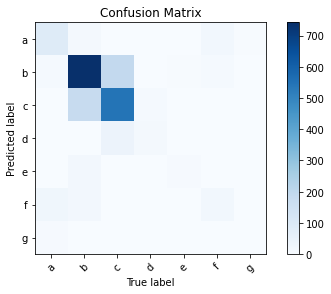

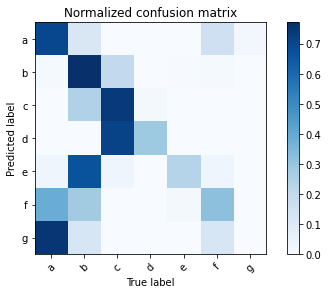

In [5]:
def plot_confusion_matrix(cm, names, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.xlabel("True label")
    plt.ylabel("Predicted label")

cm = metrics.confusion_matrix(oos_y, oos_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, products)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, products, title='Normalized confusion matrix')

plt.show()